In [1]:
import json, os, sys, collections, itertools,random
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, classification_report
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import Trainer, TrainingArguments
sys.path.append("../src")

In [2]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
      'accuracy': acc,
    }

# Load data

In [3]:
commands = {
    0:"Nothing",
    1:"Put",
    2:"Remove",
    3:"Use",
    4:"Unuse",
    5:"Check",
    6:"Do",
    7:"Move",
}
command2idx = {
        "NOOP": 0,
        "PUT": 1,
        "REMOVE": 2,
        "USE": 3,
        "STOP_USING": 4,
        "CHEF_CHECK": 5,
        "CHEF_DO": 6,
        "MOVE_CONTENTS": 7,
    }
with open("../data/ingredients.json", 'r') as f:
    ingredients = dict(json.load(f))
with open("../data/resources.json", 'r') as f:
    resources = json.load(f)
    resources = [(r["id"], r["name"]) for r in resources if 'children' not in r] + [(r["id"], lst["name"]+'/'+r["name"]) for lst in resources if 'children' in lst for r in lst["children"]]
    resources = {k:v for k,v in resources if not k.startswith("VALID_")}
    res2idx = {k:i for i,k in enumerate(resources.keys())}

In [4]:
arg2idx = res2idx
k=len(arg2idx)+1
with open("../data/arg2idx.json", 'r') as f:
    for w, i in json.load(f).items():
        arg2idx[w.replace('-', '_')] = k
        k += 1

# Preprocessing

In [5]:
def triplet_split(s):
    ret = []
    s=s.split()
    for i,t in enumerate(s):
        if i%3==0:
            ret.append([])
        ret[-1].append(t)
    return ret
df = pd.read_csv("seq2seq_4335716.csv")
df["triplet_n"] = df["output_seq"].str.split().str.len()//3
df["triplet_seq"] = df["output_seq"].apply(triplet_split)

df.sample(10)

,input_seq,output_seq,triplet_n,triplet_seq
84,stir in mustard and beef broth .,MOVE_CONTENTS STOVE_MEDLOW APPL_BLEND MOVE_CON...,6,"[[MOVE_CONTENTS, STOVE_MEDLOW, APPL_BLEND], [M..."
397,"before serving , stir in dill .",PUT IlNbCt_kq STOVE_MED,1,"[[PUT, IlNbCt_kq, STOVE_MED]]"
21,"place tomatoes , onions , red peppers , tomato...",PUT IaGLvtAKO APPL_BLEND PUT IqSsJ8Pki APPL_BL...,8,"[[PUT, IaGLvtAKO, APPL_BLEND], [PUT, IqSsJ8Pki..."
454,stir in parsley and salt ;,USE TSPATULA STOVE_MEDLOW PUT IzrIHcuDJ STOVE_...,3,"[[USE, TSPATULA, STOVE_MEDLOW], [PUT, IzrIHcuD..."
352,sprinkle with cheese over top .,REMOVE I10_d4pRP STOVE_MEDLOW REMOVE Iz0wiMjVJ...,3,"[[REMOVE, I10_d4pRP, STOVE_MEDLOW], [REMOVE, I..."
488,cut unpeeled potatoes and zucchini into 1/2 ''...,USE TGRATER COUNTER1 PUT IjuICeYOR COUNTER1,2,"[[USE, TGRATER, COUNTER1], [PUT, IjuICeYOR, CO..."
394,add the potatoes and stock ( or water ) and si...,PUT IjuICeYOR STOVE_MED PUT IlGA3C7DK STOVE_ME...,3,"[[PUT, IjuICeYOR, STOVE_MED], [PUT, IlGA3C7DK,..."
74,"reduce heat to low and cook , covered , for 6 ...",MOVE_CONTENTS STOVE_MEDHI STOVE_LOW MOVE_CONTE...,6,"[[MOVE_CONTENTS, STOVE_MEDHI, STOVE_LOW], [MOV..."
490,add potatoes and stir fry for 1 minute .,USE TSKILLET STOVE_MEDHI PUT Ixa8FQ0B6 STOVE_M...,2,"[[USE, TSKILLET, STOVE_MEDHI], [PUT, Ixa8FQ0B6..."
447,brush with oil and lay on rack in roasting pan .,MOVE_CONTENTS APPL_BLEND SERVE MOVE_CONTENTS C...,4,"[[MOVE_CONTENTS, APPL_BLEND, SERVE], [MOVE_CON..."


<AxesSubplot:ylabel='Frequency'>

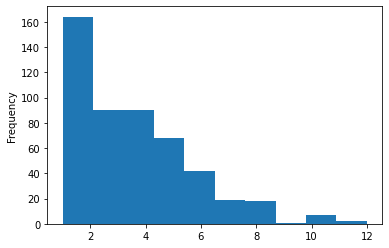

In [6]:
df["triplet_n"].plot.hist()

In [7]:
sentence_idx = list(df.index)
random.shuffle(sentence_idx)
train_idx = sentence_idx[:int(0.8*len(sentence_idx))]

In [8]:
df_prep = df.query("triplet_n<6").explode("triplet_seq")
df_prep.index.name="sentence_index"
df_prep["command"]  =  df_prep["triplet_seq"].apply(lambda x: command2idx[x[0]])
df_prep["arg"]      =  df_prep["triplet_seq"].apply(lambda x: arg2idx[x[1]])
df_prep["resource"] =  df_prep["triplet_seq"].apply(lambda x: res2idx[x[2]])
df_prep=df_prep[["input_seq", "command", "arg", "resource"]].reset_index()
df_prep["conditioned_seq"] = df_prep["command"].map(commands) + " <s> " + df_prep["input_seq"]
df_prep["train"]=df_prep["sentence_index"].isin(train_idx)
df_prep

,sentence_index,input_seq,command,arg,resource,conditioned_seq,train
0,0,brown meat in a big skillet .,3,143,11,Use<s>brown meat in a big skillet .,True
1,0,brown meat in a big skillet .,1,52,11,Put<s>brown meat in a big skillet .,True
2,0,brown meat in a big skillet .,5,119,11,Check<s>brown meat in a big skillet .,True
3,1,"remove from heat and drain the fat , if any .",7,11,21,"Move<s>remove from heat and drain the fat , if...",True
4,1,"remove from heat and drain the fat , if any .",3,143,21,"Use<s>remove from heat and drain the fat , if ...",True
...,...,...,...,...,...,...,...
1223,497,"then cover with hot water , season with walt a...",5,128,11,"Check<s>then cover with hot water , season wit...",True
1224,498,add the rice and cook for 15 minutes longer .,1,51,11,Put<s>add the rice and cook for 15 minutes lon...,True
1225,498,add the rice and cook for 15 minutes longer .,5,128,11,Check<s>add the rice and cook for 15 minutes l...,True
1226,499,"add the cheese , stir gently and turn off the ...",1,67,11,"Put<s>add the cheese , stir gently and turn of...",True


<AxesSubplot:ylabel='Frequency'>

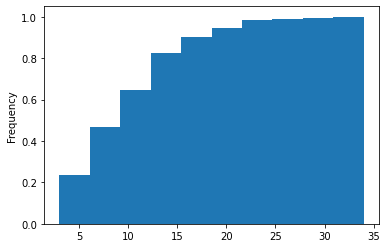

In [9]:
df_prep["input_seq"].str.split().str.len().plot.hist(density=True, cumulative=True)

# Command Model

In [10]:
max_length=20
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [11]:
class SingleInstructionDataset(torch.utils.data.Dataset):
    def __init__(self, df, text, train, target, max_length, **filters):
        if filters:
            for col,val in filters.items():
                df=df[df[col]==val]
        self.encodings = tokenizer(list(df[df["train"]==train][text]), truncation=True, padding=True, max_length=max_length)
        self.labels = list(df[df["train"]==train][target])

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
command_train_dataset = SingleInstructionDataset(df_prep, "input_seq", True,  "command", max_length)
command_valid_dataset = SingleInstructionDataset(df_prep, "input_seq", False, "command", max_length)

In [12]:
command_names = list(command2idx.keys())
command_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(command_names)).to("cuda")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [13]:
command_training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)
command_trainer = Trainer(
    model=command_model,                 # the instantiated Transformers model to be trained
    args=command_training_args,                  # training arguments, defined above
    train_dataset=command_train_dataset,         # training dataset
    eval_dataset=command_valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)
command_trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
200,1.700200,1.523156,0.385714,0.241500,869.435000
400,1.363200,1.823683,0.380952,0.219700,955.992000
600,1.286600,1.802947,0.285714,0.220500,952.438000
800,1.182500,1.964798,0.400000,0.218800,959.569000
1000,1.103600,2.010527,0.328571,0.217000,967.959000
1200,1.062400,2.037496,0.380952,0.217300,966.285000
1400,1.006600,2.223601,0.366667,0.217800,964.387000
1600,0.965300,2.243315,0.376190,0.218700,960.320000
1800,0.925000,2.212500,0.376190,0.219700,955.665000


TrainOutput(global_step=1920, training_loss=1.1601832071940104, metrics={'train_runtime': 245.4711, 'train_samples_per_second': 7.822, 'total_flos': 456823858003200.0, 'epoch': 30.0, 'init_mem_cpu_alloc_delta': 8125505, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 23295, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 3096866, 'train_mem_gpu_alloc_delta': 2007215616, 'train_mem_cpu_peaked_delta': 154965869, 'train_mem_gpu_peaked_delta': 0})

In [14]:
command_model.save_pretrained("command_model")

In [15]:
def command_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = command_model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return command_names[probs.argmax()]
command_prediction("brown meat in large skillet")

'USE'

In [16]:
command_prediction("add the onion , celery and tomaotes .")

'PUT'

In [17]:
command_prediction("stir until well mixed .")

'MOVE_CONTENTS'

In [18]:
command_prediction("add sugar, lemon and spice")

'PUT'

In [19]:
tokenizer("<s>")

{'input_ids': [0, 0, 2], 'attention_mask': [1, 1, 1]}

# Models for arg and resource

In [49]:
arg_names = list(arg2idx.keys())
arg_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(arg_names)).to("cuda")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RuntimeError: CUDA error: device-side assert triggered

In [50]:
resource_names = list(res2idx.keys())
resource_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(resource_names)).to("cuda")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
arg_train_dataset = SingleInstructionDataset(df_prep, "conditioned_seq", True,  "arg", max_length)
arg_valid_dataset = SingleInstructionDataset(df_prep, "conditioned_seq", False, "arg", max_length)
resource_train_dataset = SingleInstructionDataset(df_prep, "conditioned_seq", True,  "resource", max_length)
resource_valid_dataset = SingleInstructionDataset(df_prep, "conditioned_seq", False, "resource", max_length)

In [ ]:
arg_training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)
resource_training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [ ]:
arg_trainer = Trainer(
    model=arg_model,                 # the instantiated Transformers model to be trained
    args=arg_training_args,                  # training arguments, defined above
    train_dataset=arg_train_dataset,         # training dataset
    eval_dataset=arg_valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)
resource_trainer = Trainer(
    model=resource_model,                 # the instantiated Transformers model to be trained
    args=resource_training_args,                  # training arguments, defined above
    train_dataset=resource_train_dataset,         # training dataset
    eval_dataset=resource_valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [ ]:
arg_trainer.train()

In [45]:
resource_trainer.train()

RuntimeError: CUDA error: device-side assert triggered

In [29]:
df_prep

,sentence_index,input_seq,command,arg,resource,conditioned_seq,train
0,0,brown meat in a big skillet .,3,143,11,Use<s>brown meat in a big skillet .,True
1,0,brown meat in a big skillet .,1,52,11,Put<s>brown meat in a big skillet .,True
2,0,brown meat in a big skillet .,5,119,11,Check<s>brown meat in a big skillet .,True
3,1,"remove from heat and drain the fat , if any .",7,11,21,"Move<s>remove from heat and drain the fat , if...",True
4,1,"remove from heat and drain the fat , if any .",3,143,21,"Use<s>remove from heat and drain the fat , if ...",True
...,...,...,...,...,...,...,...
1223,497,"then cover with hot water , season with walt a...",5,128,11,"Check<s>then cover with hot water , season wit...",True
1224,498,add the rice and cook for 15 minutes longer .,1,51,11,Put<s>add the rice and cook for 15 minutes lon...,True
1225,498,add the rice and cook for 15 minutes longer .,5,128,11,Check<s>add the rice and cook for 15 minutes l...,True
1226,499,"add the cheese , stir gently and turn off the ...",1,67,11,"Put<s>add the cheese , stir gently and turn of...",True
